In [35]:
import os
import time 

import rasterio as rio
import numpy as np 
import pandas as pd
from rasterio.plot import reshape_as_raster, reshape_as_image

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

#### Definice problému

##### Local Climate Zones

Stewart and Oke (2012) proposed the Local Climate Zones (LCZ) concept which is designed to categorize urban and rural surfaces according to their climate-relevant properties into classes with relatively homogeneous air temperatures within the urban canopy layer. 

The classification legend consists of 10 urban LCZ types and 7 natural LCZ types, which are comparable across cities globally, e.g., open highrise, compact midrise, large lowrise, dense trees or water. Each class is subject to a consistent urban morphology, which is characterized by a set of value ranges for geometric and surface cover parameters, e.g., impervious surface fraction, average building height, surface albedo, or anthropogenic heat output.

LCZ is a standard for worldwide urban structure classification. Comprehensive LCZ classifications are of particular interest for urban planners and policy makers as they can serve as input for modeling tasks: LCZ characteristics are associated with urban canopy parameters and are therefore used in urban energy and water budget models as well as for climate forecasting.
![LCZ](https://ars.els-cdn.com/content/image/1-s2.0-S0924271619302205-gr1_lrg.jpg)

##### Methodology

In 2015, World Urban Database and Access Portal Tools (WUDAPT) proposed a straightforward workflow for deriving LCZ maps, which includes the manual collection of training areas in Google Earth and a subsequent classification of multispectral Landsat data using a Random Forest (RF) approach. To be able to map the contextual LCZ classes, Landsat data is commonly resampled to lower resolution of 100 m. Then, the satellite and pre-collected reference data from Google Earth are used to map LCZs at the 100 m resolution using a random forest classifier. It has become a standard for LCZ mapping and is widely adopted.

The WUDAPT-based LCZ maps, however, are still limited in terms of classification accuracy. The average Overall Accuracy (OA) of the 90 LCZs uploaded on the WUDAPT portal is 74.5%, leaving much room for improvement. In particular, the average OA of the urban LCZ types of the 90 LCZs is just 59.3%, which means that the urban LCZ types are not as accurate as the other general natural LCZ types such as forest and water. The low classification accuracy of urban features urban LCZ types is a major limitation for urban climate-related research.

![Methodology](https://ars.els-cdn.com/content/image/1-s2.0-S0924271619302205-gr4_lrg.jpg)

##### Data

Sentinel-2 images, 19.5.2017

##### Data Preprocessing

4 Sentinel-2 images covering Berlin, Germany were downloaded from Copernicus DataHub as ZIP files. From ZIP files only the 10 and 20 m bands were extracted and saved as .tif files. Using these .tif files the 10 m and 20 m mosaic was created. Mosaic was clipped to the Ground Truth (labels) raster extent. The 20 m mosaic was resampled to 10 m and these two mosaics were merged together - forming an image of 10 m resolution, covering whole Berlin and containing these 10 spectral bands: \
Originally 10 m bands: B1 red; B2 green; B3 blue; B4 NIR \
Originally 20 m bands resampled to 10 m: B7 Red Edge 1; B8 Red Edge 2; B9 Red Edge 3; B10 NIR2 (B8A); B11 SWIR1; B12 SWIR2

Apart from downloading the data, all preprocessing was done using Python scripting.

In [ ]:
# definicia tried a legendy
class_names = dict((
(0, 'Background'),
(1, 'Compact High-rise'),
(2, 'Compact Mid-rise'),
(3, 'Compact Low-rise'),
(4, 'Open High-rise'),
(5, 'Open Mid-rise'),
(6, 'Open Low-rise'),
(7, 'Lightweight Low-rise'),
(8, 'Large low-rise'),
(9, 'Sparsely built'),
(10, 'Heavy industry'),
(11, 'Dense Trees'),
(12, 'Scattered Trees'),
(13, 'Bush, Scrubs'),
(14, 'Low Plants'),
(15, 'Bare rock or paved'),
(16, 'Bare soil or sand'),
(17, 'Water')
))

# next setup a colormap for our map
colors = dict((
(0, (255,255,255,255)), # Background
(1, (0,0,0)), # Compact High-rise (not set)
(2, (209,0,0)), # Compact Mid-rise
(3, (0,0,0)), # Compact Low-rise (not set)
(4, (191, 77, 0)), # Open High-rise
(5, (255, 102, 0)), # Open Mid-rise
(6, (255, 153, 85)), # Open Low-rise
(7, (0,0,0)), # Lightweight Low-rise (not set)
(8, (188, 188, 188)), # Large low-rise
(9, (255, 204, 170)), # Sparsely built
(10, (0,0,0)), # Heavy industry (not set)
(11, (0, 106, 0)), # Dense Trees
(12, (0, 170, 0)), # Scattered Trees
(13, (100, 133, 37)), # Bush, Scrubs
(14, (185, 219, 121)), # Low Plants
(15, (0,0,0)), # Bare rock or paved (not set)
(16, (251, 247, 174)), # Bare soil or sand
(17, (106, 106, 255)), # Water
))

#### Průzkum dat

In [2]:
image_fr_fn = 'composite_subset.tif'
mean_100grid_fn = '100m_mean_grid.tif'

In [3]:
with rio.open(image_fr_fn) as fr_data:
    meta_fr = fr_data.meta
    image_fr = fr_data.read()

print('Original Image:')
print(meta_fr)
print(image_fr.shape)

with rio.open(mean_100grid_fn) as mean_100grid_data:
    meta_mean_100grid = mean_100grid_data.meta
    mean_100grid = mean_100grid_data.read()

print('------')
print('100m grid - mean features:')
print(meta_mean_100grid)
print(mean_100grid.shape)

Original Image:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 6434, 'height': 6664, 'count': 10, 'crs': CRS.from_epsg(32633), 'transform': Affine(9.994790578207187, 0.0, 360276.48325961066,
       0.0, -9.994790578207187, 5855923.040170476)}
(10, 6664, 6434)
------
100m grid - mean features:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 643, 'height': 666, 'count': 10, 'crs': CRS.from_epsg(32633), 'transform': Affine(100.01008177322726, 0.0, 360276.48325961066,
       0.0, -100.00793455431337, 5855923.040170476)}
(10, 666, 643)


In [4]:
# Reference ("labels") pro klasifikaci
ref_fn = 'berlin_lcz_GT.tif'

In [5]:
# Unikátní kódy 
with rio.open(ref_fn) as ref_data:
    labels = ref_data.read(1)

print(np.unique(labels, return_counts=True))

(array([ 0,  2,  4,  5,  6,  8,  9, 11, 12, 13, 14, 16, 17], dtype=uint8), array([403701,   1534,    577,   2448,   4010,   1654,    761,   4960,
         1028,   1050,   4424,    359,   1732], dtype=int64))


In [6]:
labels.shape

(666, 643)

In [7]:
labels_reshaped = labels.reshape(-1)
labels_reshaped.shape

(428238,)

In [8]:
# remap class values to 0 to n
# Generate a mapping dictionary from the unique values to a continuous range
unique_labels = np.unique(labels_reshaped)
mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}

# Apply the mapping to the original labels array
remapped_labels = np.array([mapping[label] for label in labels_reshaped])

print("Remapped labels:", np.unique(remapped_labels, return_counts=True))
print(remapped_labels.shape)

Remapped labels: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([403701,   1534,    577,   2448,   4010,   1654,    761,   4960,
         1028,   1050,   4424,    359,   1732], dtype=int64))
(428238,)


In [9]:
# definicia tried a legendy
class_names = dict((
(0, 'Background'),
(1, 'Compact Mid-rise'),
(2, 'Open High-rise'),
(3, 'Open Mid-rise'),
(4, 'Open Low-rise'),
(5, 'Large low-rise'),
(6, 'Sparsely built'),
(7, 'Dense Trees'),
(8, 'Scattered Trees'),
(9, 'Bush, Scrubs'),
(10, 'Low Plants'),
(11, 'Bare soil or sand'),
(12, 'Water')
))

# next setup a colormap for our map
colors = dict((
(0, (255,255,255,255)), # Background
(1, (209,0,0)), # Compact Mid-rise
(2, (191, 77, 0)), # Open High-rise
(3, (255, 102, 0)), # Open Mid-rise
(4, (255, 153, 85)), # Open Low-rise
(5, (188, 188, 188)), # Large low-rise
(6, (255, 204, 170)), # Sparsely built
(7, (0, 106, 0)), # Dense Trees
(8, (0, 170, 0)), # Scattered Trees
(9, (100, 133, 37)), # Bush, Scrubs
(10, (185, 219, 121)), # Low Plants
(11, (251, 247, 174)), # Bare soil or sand
(12, (106, 106, 255)), # Water
))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.0].


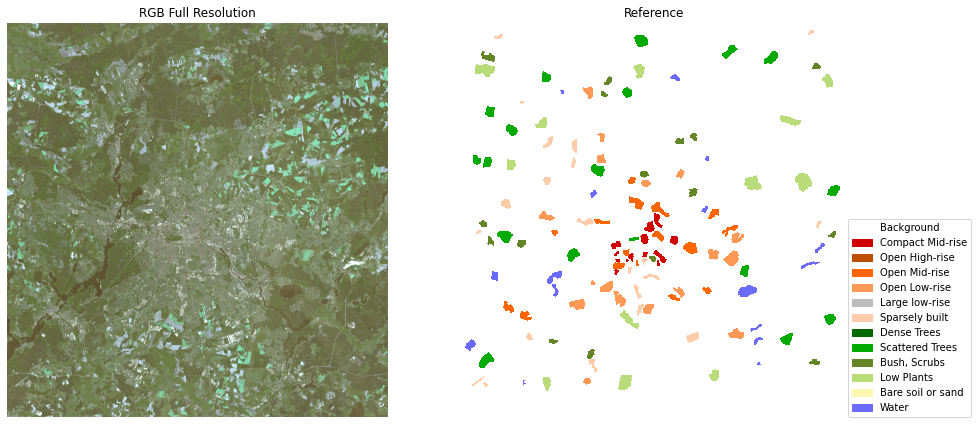

In [10]:
# full resolution data RGB visualization
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

blue_fr=image_fr[2]
green_fr=image_fr[1]
red_fr=image_fr[0]

blue_fr_norm = normalize(blue_fr)
green_fr_norm = normalize(green_fr)
red_fr_norm = normalize(red_fr)

rgb_image_fr_norm = np.array([blue_fr_norm,green_fr_norm,red_fr_norm])
rgb_image_fr_norm = rio.plot.reshape_as_image(rgb_image_fr_norm)

# reference visualization
n = int(np.max(remapped_labels)) + 1

for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_false_colors = [colors[key] for key in range(0, n)]
cmap_false_colors = plt.matplotlib.colors.ListedColormap(index_false_colors, 'Classification', n)

import matplotlib.patches as mpatches
patches =[mpatches.Patch(color=cmap_false_colors.colors[class_id],label=class_names[class_id]) 
          for class_id in range(len(cmap_false_colors.colors))]

# plotting
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(rgb_image_fr_norm*6)
ax1.set_title('RGB Full Resolution')
ax1.set_axis_off()
ax2.imshow(labels, cmap=cmap_false_colors, interpolation='none')
ax2.legend(handles=patches,loc=(1.01,0), borderaxespad=0.)
ax2.set_title('Reference')
ax2.set_axis_off();

### Klasifikace 1 (100m mean grid - Random Forest)

#### Příprava dat pro klasifikaci

In [11]:
# vektorizace trenovacich pixelov a vyber reference 
mean_100grid_reshaped = rio.plot.reshape_as_image(mean_100grid)
print(f'Image shape: {mean_100grid.shape} -> {mean_100grid_reshaped.shape}')

X = mean_100grid_reshaped[labels > 0]
y = remapped_labels[remapped_labels > 0]

print('Vstup X má rozměr: {sz}'.format(sz=X.shape))
print('Výstup y má rozměr: {sz}'.format(sz=y.shape))

# ověřte unikátní kódy tříd klasifikace 
print(f'Triedy:\n{np.unique(y, return_counts=True)}')

Image shape: (10, 666, 643) -> (666, 643, 10)
Vstup X má rozměr: (24537, 10)
Výstup y má rozměr: (24537,)
Triedy:
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([1534,  577, 2448, 4010, 1654,  761, 4960, 1028, 1050, 4424,  359,
       1732], dtype=int64))


In [12]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)

for train_indices, test_indices in sss.split(X,y):
    X_train = X[train_indices]
    y_train = y[train_indices]

    X_test = X[test_indices]
    y_test = y[test_indices]

In [13]:
print(f'Trening: {X_train.shape, y_train.shape}')
print(f'Testing: {X_test.shape, y_test.shape}')

Trening: ((14722, 10), (14722,))
Testing: ((9815, 10), (9815,))


#### Model - default parameters

In [14]:
model = RandomForestClassifier(random_state=0, n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

#### Evaluation

In [15]:
# presnost na trenovacich datech
y_train_pred = model.predict(X_train)

acc_train = accuracy_score(y_train, y_train_pred)
round(acc_train, 7)

1.0

In [16]:
# presnost na testovacich datech
y_test_pred = model.predict(X_test)

acc_test = accuracy_score(y_test, y_test_pred)
round(acc_test,7)

0.770759

#### Finetuning 
##### Finding optimal hyperparameters - GridSearch

In [17]:
rf = RandomForestClassifier(random_state=0, n_jobs=-2)
rf

RandomForestClassifier(n_jobs=-2, random_state=0)

In [18]:
hyperparameter_space = {'n_estimators': [100, 300, 500],
                        'max_features': ['sqrt', 2, 5, 8],
                        'max_depth': [4,6,8,10,15],
                        'min_samples_leaf': [1,10,20]}

gs = GridSearchCV(rf, param_grid=hyperparameter_space, n_jobs=-2,
                  scoring="accuracy", cv=5, return_train_score=True)

In [19]:
start = time.time()

gs.fit(X_train, y_train)

print('---')
time_elapsed = time.time() - start
print('Grid search duration: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))   

C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


---
Grid search duration: 17m 36s


In [20]:
# Optimal parameters and scores 
print("Optimal hyperparameter combination: ", gs.best_params_)
print("Mean cross-validated accuracy of the best_estimator: ", round(gs.best_score_ * 100, 2))

Optimal hyperparameter combination:  {'max_depth': 15, 'max_features': 5, 'min_samples_leaf': 1, 'n_estimators': 300}
Mean cross-validated accuracy of the best_estimator:  76.64


In [21]:
res = gs.cv_results_
for score, params in zip(res['mean_test_score'], res['params']):
    print(score, params)

0.6655345510076032 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
0.6633611223887208 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}
0.6626138859157009 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}
0.6615951409906252 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 100}
0.6624101969070643 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 300}
0.661663052705396 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 500}
0.6613234249280283 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 100}
0.6619346995644793 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 300}
0.6612554440097439 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 500}
0.6617310797593563 {'max_depth': 4, 'max_features': 2, 'min

In [22]:
# natrenuj model s optimalnymi hyperparametrami
gs.best_estimator_.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=5, n_estimators=300,
                       n_jobs=-2, random_state=0)

In [23]:
# presnost na trenovacich datech
y_train_pred = gs.best_estimator_.predict(X_train)

acc_train = accuracy_score(y_train, y_train_pred)
round(acc_train, 7)

0.9246706

In [24]:
# presnost na testovacich
y_test_pred = gs.best_estimator_.predict(X_test)

acc_test = accuracy_score(y_test, y_test_pred)
round(acc_test,7)

0.7660723

##### Finetuning Max Depth

In [25]:
# Tree max depth  1 - 20
depth = [d+1 for d in range(20)]

train_accuracy = []
test_accuracy = []
for d in depth:
    # model
    model = RandomForestClassifier(random_state=0, n_estimators=300, max_features=5, n_jobs=-2, max_depth=d)
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)

    # Evaluation
    train_acc = accuracy_score(y_train, y_train_pred)
    
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Compare
    print(f'Depth: {d}, Trening: {round(train_acc*100, 2)}, Testing: {round(test_acc*100, 2)}, Gap: {abs(round((train_acc-test_acc)*100, 2))}')
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

Depth: 1, Trening: 46.14, Testing: 46.16, Gap: 0.03
Depth: 2, Trening: 54.69, Testing: 54.71, Gap: 0.03
Depth: 3, Trening: 62.2, Testing: 62.53, Gap: 0.33
Depth: 4, Trening: 66.08, Testing: 66.35, Gap: 0.26
Depth: 5, Trening: 69.73, Testing: 68.97, Gap: 0.77
Depth: 6, Trening: 71.62, Testing: 70.26, Gap: 1.36
Depth: 7, Trening: 73.2, Testing: 71.57, Gap: 1.63
Depth: 8, Trening: 74.68, Testing: 72.24, Gap: 2.44
Depth: 9, Trening: 76.65, Testing: 73.08, Gap: 3.57
Depth: 10, Trening: 78.97, Testing: 73.93, Gap: 5.04
Depth: 11, Trening: 81.62, Testing: 74.74, Gap: 6.88
Depth: 12, Trening: 84.61, Testing: 75.39, Gap: 9.22
Depth: 13, Trening: 87.49, Testing: 75.89, Gap: 11.6
Depth: 14, Trening: 90.06, Testing: 76.1, Gap: 13.96
Depth: 15, Trening: 92.47, Testing: 76.61, Gap: 15.86
Depth: 16, Trening: 94.0, Testing: 76.74, Gap: 17.26
Depth: 17, Trening: 95.21, Testing: 76.92, Gap: 18.29
Depth: 18, Trening: 96.01, Testing: 77.08, Gap: 18.93
Depth: 19, Trening: 96.79, Testing: 77.11, Gap: 19.69


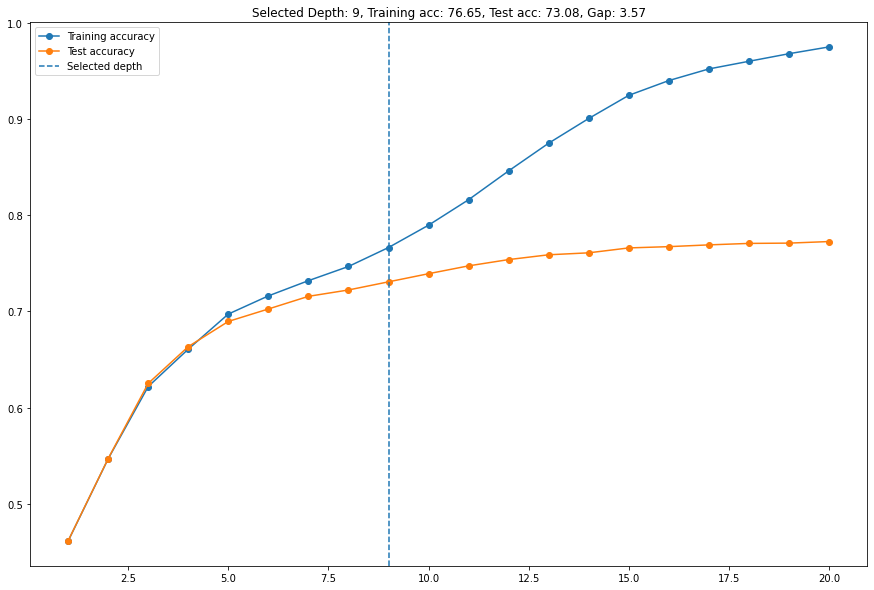

In [27]:
selected_depth = 9

plt.plot(depth, train_accuracy, '-o', label='Training accuracy')
plt.plot(depth, test_accuracy, '-o', label='Test accuracy')
plt.axvline(x = selected_depth, linestyle='--', label='Selected depth')
plt.legend()
plt.title(f'Selected Depth: {selected_depth}, Training acc: {round((train_accuracy[selected_depth-1])*100,2)}, Test acc: {round((test_accuracy[selected_depth-1])*100,2)}, Gap: {round(abs((train_accuracy[selected_depth-1]*100)-(test_accuracy[selected_depth-1]*100)),2)}');

#### Model - optimal parameters

In [28]:
model = RandomForestClassifier(n_estimators=300, max_features=5, max_depth=selected_depth, random_state=0, n_jobs=-2)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_features=5, n_estimators=300, n_jobs=-2,
                       random_state=0)

In [29]:
# presnost na trenovacich datech
y_train_pred = model.predict(X_train)

acc_train = accuracy_score(y_train, y_train_pred)
round(acc_train, 7)

0.7664719

In [30]:
# presnost na testovacich
y_test_pred = model.predict(X_test)

acc_test = accuracy_score(y_test, y_test_pred)
round(acc_test,7)

0.7308202

#### Prediction

In [31]:
# Příprava pro predikci - vektorizace matice
scene = mean_100grid_reshaped.reshape(-1, mean_100grid_reshaped.shape[-1])
print(f'Image shape for classification: {mean_100grid_reshaped.shape} -> {scene.shape}')

Image shape for classification: (666, 643, 10) -> (428238, 10)


In [32]:
# Predikce
y_pred = model.predict(scene)

print(y_pred.shape)
np.unique(y_pred)

(428238,)


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [33]:
# Návrat do 2D matice
classified_scene = y_pred.reshape(mean_100grid_reshaped.shape[0], mean_100grid_reshaped.shape[1])

print(f'Predicted labels shape: {y_pred.shape} -> {classified_scene.shape}')

Predicted labels shape: (428238,) -> (666, 643)


#### Feature Importance

In [34]:
feature_names = ['red','green','blue','NIR','Red Edge 1','Red Edge 2','Red Edge 3','NIR2','SWIR1','SWIR2']

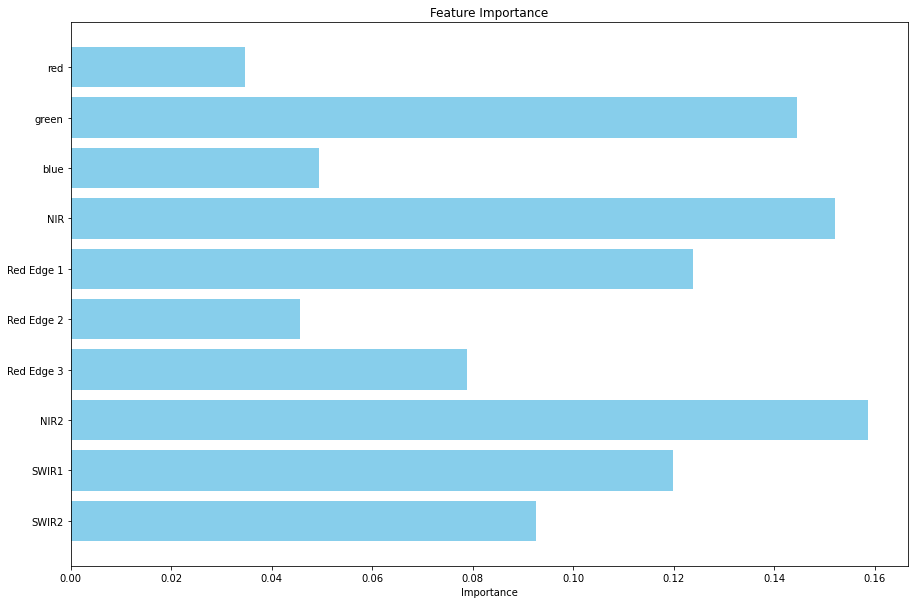

In [36]:
#feature importance
importances = model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)

plt.figure()
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()

#### Classification visualization and Export

In [37]:
# definicia tried a legendy
class_names = dict((
(0, 'Compact Mid-rise'),
(1, 'Open High-rise'),
(2, 'Open Mid-rise'),
(3, 'Open Low-rise'),
(4, 'Large low-rise'),
(5, 'Sparsely built'),
(6, 'Dense Trees'),
(7, 'Scattered Trees'),
(8, 'Bush, Scrubs'),
(9, 'Low Plants'),
(10, 'Bare soil or sand'),
(11, 'Water')
))

# next setup a colormap for our map
colors = dict((
(0, (209,0,0)), # Compact Mid-rise
(1, (191, 77, 0)), # Open High-rise
(2, (255, 102, 0)), # Open Mid-rise
(3, (255, 153, 85)), # Open Low-rise
(4, (188, 188, 188)), # Large low-rise
(5, (255, 204, 170)), # Sparsely built
(6, (0, 106, 0)), # Dense Trees
(7, (0, 170, 0)), # Scattered Trees
(8, (100, 133, 37)), # Bush, Scrubs
(9, (185, 219, 121)), # Low Plants
(10, (251, 247, 174)), # Bare soil or sand
(11, (106, 106, 255)), # Water
))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.0].


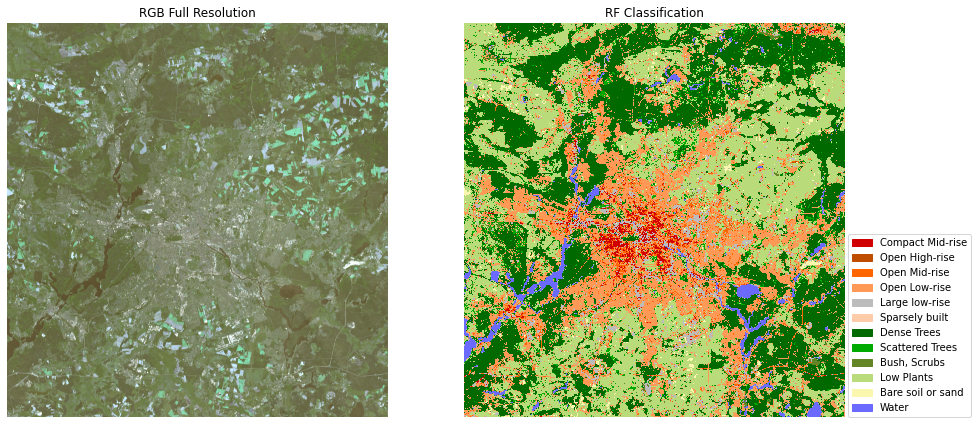

In [38]:
# classification vidualization
n = int(np.max(y_pred))

for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_false_colors = [colors[key] for key in range(0, n)]
cmap_false_colors = plt.matplotlib.colors.ListedColormap(index_false_colors, 'Classification', n)

import matplotlib.patches as mpatches
patches =[mpatches.Patch(color=cmap_false_colors.colors[class_id],label=class_names[class_id]) 
          for class_id in range(len(cmap_false_colors.colors))]

# plotting
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(rgb_image_fr_norm*6)
ax1.set_title('RGB Full Resolution')
ax1.set_axis_off()
ax2.imshow(classified_scene, cmap=cmap_false_colors, interpolation='none')
ax2.legend(handles=patches,loc=(1.01,0), borderaxespad=0.)
ax2.set_title('RF Classification')
ax2.set_axis_off();

In [39]:
# Remap class valus back
inverse_mapping = {new_label: old_label for old_label, new_label in mapping.items()}

# Apply the inverse mapping to the remapped labels
predicted_original_labels = np.array([inverse_mapping[label] for label in y_pred])

# Verify
print("Original labels:", np.unique(predicted_original_labels))
print(predicted_original_labels.shape)

Original labels: [ 2  4  5  6  8  9 11 12 13 14 16 17]
(428238,)


In [40]:
classified_scene = predicted_original_labels.reshape(mean_100grid_reshaped.shape[0], mean_100grid_reshaped.shape[1])

print(f'Predicted labels shape: {predicted_original_labels.shape} -> {classified_scene.shape}')

Predicted labels shape: (428238,) -> (666, 643)


In [41]:
rf_fp = 'RF_LCZ_classification.tif'

classification_meta = meta_mean_100grid.copy()
classification_meta.update({"count": 1})

with rio.open(rf_fp, "w", **classification_meta) as dest:
    dest.write(classified_scene, indexes=1)

### Klasifikace 2 (100m mean, min, max grid - Random Forest)

In [42]:
mean_min_max_100grid_fn = '100m_mean_min_max_grid.tif'

In [43]:
with rio.open(mean_min_max_100grid_fn) as mean_min_max_100grid_data:
    meta_mean_min_max_100grid = mean_min_max_100grid_data.meta
    mean_min_max_100grid = mean_min_max_100grid_data.read()

print('100m grid - mean, min, max features:')
print(meta_mean_min_max_100grid)
print(mean_min_max_100grid.shape)

100m grid - mean, min, max features:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 643, 'height': 666, 'count': 30, 'crs': CRS.from_epsg(32633), 'transform': Affine(100.01008177322713, 0.0, 360276.48325961066,
       0.0, -100.00793455431335, 5855923.040170476)}
(30, 666, 643)


In [44]:
mean_min_max_100grid_reshaped = rio.plot.reshape_as_image(mean_min_max_100grid)
print(f'Image shape: {mean_min_max_100grid.shape} -> {mean_min_max_100grid_reshaped.shape}')

X = mean_min_max_100grid_reshaped[labels > 0]
y = remapped_labels[remapped_labels > 0]

print('Vstup X má rozměr: {sz}'.format(sz=X.shape))
print('Výstup y má rozměr: {sz}'.format(sz=y.shape))

# ověřte unikátní kódy tříd klasifikace 
print(f'Triedy:\n{np.unique(y, return_counts=True)}')

Image shape: (30, 666, 643) -> (666, 643, 30)
Vstup X má rozměr: (24537, 30)
Výstup y má rozměr: (24537,)
Triedy:
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([1534,  577, 2448, 4010, 1654,  761, 4960, 1028, 1050, 4424,  359,
       1732], dtype=int64))


In [45]:
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

print(f'Trening: {X_train.shape, y_train.shape}')
print(f'Testing: {X_test.shape, y_test.shape}')

Trening: ((14722, 30), (14722,))
Testing: ((9815, 30), (9815,))


#### Model - default parameters

In [46]:
model = RandomForestClassifier(random_state=0, n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

#### Evaluation

In [47]:
# presnost na trenovacich datech
y_train_pred = model.predict(X_train)

acc_train = accuracy_score(y_train, y_train_pred)
round(acc_train, 7)

1.0

In [48]:
# presnost na testovacich datech
y_test_pred = model.predict(X_test)

acc_test = accuracy_score(y_test, y_test_pred)
round(acc_test,7)

0.8073357

#### Finetuning 
##### Finding optimal hyperparameters - GridSearch

In [49]:
rf = RandomForestClassifier(random_state=0, n_jobs=-2)
rf

RandomForestClassifier(n_jobs=-2, random_state=0)

In [50]:
hyperparameter_space = {'n_estimators': [100, 300, 500],
                        'max_features': ['sqrt', 2, 5, 8],
                        'max_depth': [4,6,8,10,15],
                        'min_samples_leaf': [1,10,20]}

gs = GridSearchCV(rf, param_grid=hyperparameter_space, n_jobs=-2,
                  scoring="accuracy", cv=5, return_train_score=True)

In [51]:
start = time.time()

gs.fit(X_train, y_train)

print('---')
time_elapsed = time.time() - start
print('Grid search duration: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))   

C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


---
Grid search duration: 19m 39s


In [52]:
# Optimal parameters and scores 
print("Optimal hyperparameter combination: ", gs.best_params_)
print("Mean cross-validated accuracy of the best_estimator: ", round(gs.best_score_ * 100, 2))

Optimal hyperparameter combination:  {'max_depth': 15, 'max_features': 8, 'min_samples_leaf': 1, 'n_estimators': 500}
Mean cross-validated accuracy of the best_estimator:  81.04


In [53]:
res = gs.cv_results_
for score, params in zip(res['mean_test_score'], res['params']):
    print(score, params)

0.7083951935852956 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
0.7074445679855318 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}
0.7062897920203735 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}
0.7084631514357422 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 100}
0.7079199269210896 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 300}
0.7062219033734407 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 500}
0.7075122028862479 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 100}
0.707851946002805 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 300}
0.706357772938658 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 500}
0.6967803526611058 {'max_depth': 4, 'max_features': 2, 'min_

In [54]:
# natrenuj model s optimalnymi hyperparametrami
gs.best_estimator_.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=8, n_estimators=500,
                       n_jobs=-2, random_state=0)

In [55]:
# presnost na trenovacich datech
y_train_pred = gs.best_estimator_.predict(X_train)

acc_train = accuracy_score(y_train, y_train_pred)
round(acc_train, 7)

0.9567993

In [56]:
# presnost na testovacich
y_test_pred = gs.best_estimator_.predict(X_test)

acc_test = accuracy_score(y_test, y_test_pred)
round(acc_test,7)

0.806215

##### Finetuning Max Depth

In [57]:
# Tree max depth  1 - 20
depth = [d+1 for d in range(20)]

train_accuracy = []
test_accuracy = []
for d in depth:
    # model
    model = RandomForestClassifier(random_state=0, n_estimators=300, max_features=5, n_jobs=-2, max_depth=d)
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)

    # Evaluation
    train_acc = accuracy_score(y_train, y_train_pred)
    
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Compare
    print(f'Depth: {d}, Trening: {round(train_acc*100, 2)}, Testing: {round(test_acc*100, 2)}, Gap: {abs(round((train_acc-test_acc)*100, 2))}')
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

Depth: 1, Trening: 50.33, Testing: 50.23, Gap: 0.1
Depth: 2, Trening: 58.06, Testing: 57.95, Gap: 0.11
Depth: 3, Trening: 66.25, Testing: 66.15, Gap: 0.09
Depth: 4, Trening: 70.98, Testing: 70.63, Gap: 0.36
Depth: 5, Trening: 72.78, Testing: 72.02, Gap: 0.76
Depth: 6, Trening: 75.0, Testing: 73.88, Gap: 1.13
Depth: 7, Trening: 77.1, Testing: 75.28, Gap: 1.81
Depth: 8, Trening: 79.21, Testing: 76.54, Gap: 2.68
Depth: 9, Trening: 81.8, Testing: 77.59, Gap: 4.22
Depth: 10, Trening: 84.41, Testing: 78.3, Gap: 6.11
Depth: 11, Trening: 87.13, Testing: 78.9, Gap: 8.24
Depth: 12, Trening: 89.76, Testing: 79.54, Gap: 10.22
Depth: 13, Trening: 91.95, Testing: 79.99, Gap: 11.96
Depth: 14, Trening: 93.97, Testing: 80.32, Gap: 13.65
Depth: 15, Trening: 95.58, Testing: 80.55, Gap: 15.03
Depth: 16, Trening: 96.77, Testing: 80.44, Gap: 16.34
Depth: 17, Trening: 97.85, Testing: 80.85, Gap: 17.01
Depth: 18, Trening: 98.46, Testing: 80.8, Gap: 17.65
Depth: 19, Trening: 98.83, Testing: 80.71, Gap: 18.12
D

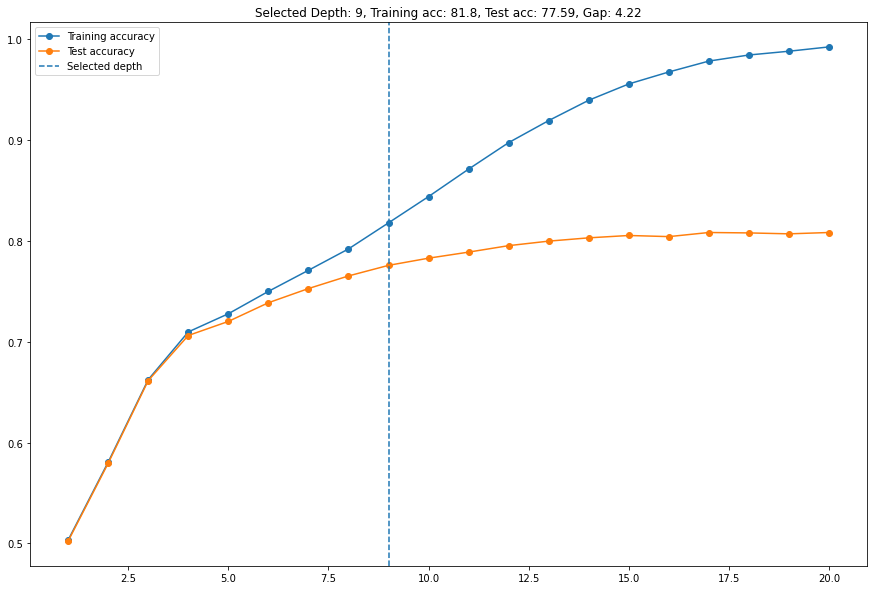

In [58]:
selected_depth = 9

plt.plot(depth, train_accuracy, '-o', label='Training accuracy')
plt.plot(depth, test_accuracy, '-o', label='Test accuracy')
plt.axvline(x = selected_depth, linestyle='--', label='Selected depth')
plt.legend()
plt.title(f'Selected Depth: {selected_depth}, Training acc: {round((train_accuracy[selected_depth-1])*100,2)}, Test acc: {round((test_accuracy[selected_depth-1])*100,2)}, Gap: {round(abs((train_accuracy[selected_depth-1]*100)-(test_accuracy[selected_depth-1]*100)),2)}');

#### Model - optimal parameters

In [59]:
model = RandomForestClassifier(n_estimators=500, max_features=8, max_depth=selected_depth, min_samples_leaf=1, random_state=0, n_jobs=-2)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_features=8, n_estimators=500, n_jobs=-2,
                       random_state=0)

In [60]:
# presnost na trenovacich datech
y_train_pred = model.predict(X_train)

acc_train = accuracy_score(y_train, y_train_pred)
round(acc_train, 7)

0.8209482

In [61]:
# presnost na testovacich
y_test_pred = model.predict(X_test)

acc_test = accuracy_score(y_test, y_test_pred)
round(acc_test,7)

0.7774834

#### Prediction

In [62]:
# Příprava pro predikci - vektorizace matice
scene = mean_min_max_100grid_reshaped.reshape(-1, mean_min_max_100grid_reshaped.shape[-1])
print(f'Image shape for classification: {mean_min_max_100grid_reshaped.shape} -> {scene.shape}')

Image shape for classification: (666, 643, 30) -> (428238, 30)


In [63]:
# Predikce
y_pred = model.predict(scene)

print(y_pred.shape)
np.unique(y_pred)

(428238,)


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [64]:
# Návrat do 2D matice
classified_scene_mean_min_max = y_pred.reshape(mean_min_max_100grid_reshaped.shape[0], mean_min_max_100grid_reshaped.shape[1])

print(f'Predicted labels shape: {y_pred.shape} -> {classified_scene_mean_min_max.shape}')

Predicted labels shape: (428238,) -> (666, 643)


#### Feature Importance

In [65]:
feature_names = ['red_mean','green_mean','blue_mean','NIR_mean','Red Edge 1_mean','Red Edge 2_mean','Red Edge 3_mean','NIR2_mean','SWIR1_mean','SWIR2_mean',
                'red_min','green_min','blue_min','NIR_min','Red Edge 1_min','Red Edge 2_min','Red Edge 3_min','NIR2_min','SWIR1_min','SWIR2_min',
                'red_max','green_max','blue_max','NIR_max','Red Edge 1_max','Red Edge 2_max','Red Edge 3_max','NIR2_max','SWIR1_max','SWIR2_max',
                ]

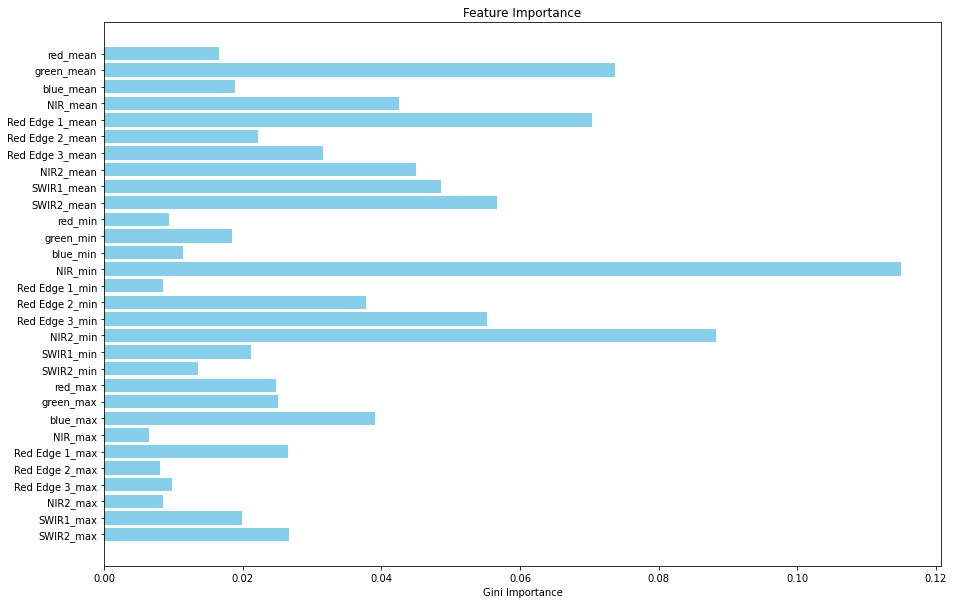

In [66]:
# feature importance
importances = model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)

plt.figure()
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Gini Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization

#### Classification visualization and Export

In [67]:
# definicia tried a legendy
class_names = dict((
(0, 'Compact Mid-rise'),
(1, 'Open High-rise'),
(2, 'Open Mid-rise'),
(3, 'Open Low-rise'),
(4, 'Large low-rise'),
(5, 'Sparsely built'),
(6, 'Dense Trees'),
(7, 'Scattered Trees'),
(8, 'Bush, Scrubs'),
(9, 'Low Plants'),
(10, 'Bare soil or sand'),
(11, 'Water')
))

# next setup a colormap for our map
colors = dict((
(0, (209,0,0)), # Compact Mid-rise
(1, (191, 77, 0)), # Open High-rise
(2, (255, 102, 0)), # Open Mid-rise
(3, (255, 153, 85)), # Open Low-rise
(4, (188, 188, 188)), # Large low-rise
(5, (255, 204, 170)), # Sparsely built
(6, (0, 106, 0)), # Dense Trees
(7, (0, 170, 0)), # Scattered Trees
(8, (100, 133, 37)), # Bush, Scrubs
(9, (185, 219, 121)), # Low Plants
(10, (251, 247, 174)), # Bare soil or sand
(11, (106, 106, 255)), # Water
))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..6.0].


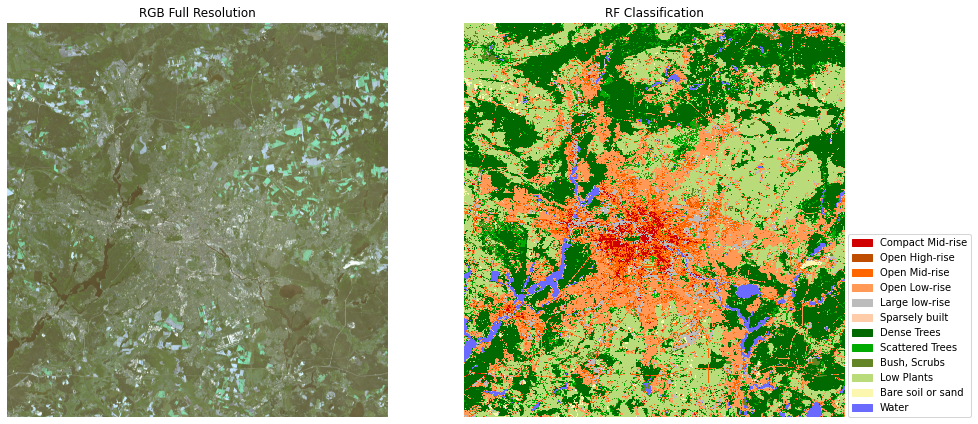

In [68]:
# classification vidualization
n = int(np.max(y_pred))

for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_false_colors = [colors[key] for key in range(0, n)]
cmap_false_colors = plt.matplotlib.colors.ListedColormap(index_false_colors, 'Classification', n)

import matplotlib.patches as mpatches
patches =[mpatches.Patch(color=cmap_false_colors.colors[class_id],label=class_names[class_id]) 
          for class_id in range(len(cmap_false_colors.colors))]

# plotting
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(rgb_image_fr_norm*6)
ax1.set_title('RGB Full Resolution')
ax1.set_axis_off()
ax2.imshow(classified_scene_mean_min_max, cmap=cmap_false_colors, interpolation='none')
ax2.legend(handles=patches,loc=(1.01,0), borderaxespad=0.)
ax2.set_title('RF Classification')
ax2.set_axis_off();

In [69]:
# Remap class valus back
inverse_mapping = {new_label: old_label for old_label, new_label in mapping.items()}

# Apply the inverse mapping to the remapped labels
predicted_original_labels = np.array([inverse_mapping[label] for label in y_pred])

# Verify
print("Original labels:", np.unique(predicted_original_labels))
print(predicted_original_labels.shape)

Original labels: [ 2  4  5  6  8  9 11 12 13 14 16 17]
(428238,)


In [70]:
classified_scene_mean_min_max = predicted_original_labels.reshape(mean_100grid_reshaped.shape[0], mean_100grid_reshaped.shape[1])

print(f'Predicted labels shape: {predicted_original_labels.shape} -> {classified_scene.shape}')

Predicted labels shape: (428238,) -> (666, 643)


In [71]:
rf_fp = 'RF_LCZ_classification_mean_min_max.tif'

classification_meta = meta_mean_100grid.copy()
classification_meta.update({"count": 1})

with rio.open(rf_fp, "w", **classification_meta) as dest:
    dest.write(classified_scene_mean_min_max, indexes=1)